# Coding Assignment 1: Music Auto-tagging Model
- In this assignment, you will train your auto-tagging model using PyTorch
- The dataset is from MagnaTagATune
  - Randomly selected 8000 mp3 files
  - 5000 files for training, 1000 for validation, 2000 for test
  
- Every code cell before the Problem 0 has to be ran without modification or error
- You have to submit three files:
  - Report in PDF (free format)
      - Explain what you have tried and what you have got as the result
      - Your submission would be evaluated mainly with the report
  - Notebook in ipynb
  - Audio data that you used for Problem 5
 

In [20]:
DEV = 'cuda'

## 0. Import Library

In [54]:
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd

## 1. Prepare Dataset
- You can use the pre-processed data

In [4]:
class MTATDataset:
  def __init__(self, dir, split='train'):
    self.dir = dir
    self.labels = pd.read_csv(dir / "meta.csv", index_col=[0])
    self.sr = 16000

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]

    self.vocab = self.labels.columns.values[1:-1]
    self.audios = self.load_audio_dataset()
    self.label_tensor = self.convert_label_to_tensor()
    
  def load_audio_dataset(self):
    return [self.load_audio_and_resample(self.dir/x) for x in tqdm(self.labels['mp3_path'].values)]

  def load_audio_and_resample(self, audio_path):
    audio, sr = torchaudio.load(audio_path)
    resampled_audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=self.sr)
    return resampled_audio.squeeze()

  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __getitem__(self, idx):
    audio = self.audios[idx]
    tag = self.label_tensor[idx]
    return audio, tag

  def __len__(self):
    return len(self.labels)

data_dir = Path('../MTAT_SMALL')
trainset = MTATDataset(data_dir)
validset = MTATDataset(data_dir, split='valid')
testset = MTATDataset(data_dir, split='test')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 101.69it/s]


- Define `DataLoader` using the dataset

In [10]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
valid_loader = DataLoader(validset, batch_size=128, shuffle=False)
test_loader = DataLoader(testset,batch_size=128, shuffle=False)

## 2. Define Neural Network
- Define the neural network

In [30]:
class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    out = self.final_layer(out)
    out = torch.sigmoid(out)
    return out

## 3. Train the Network
- First, just run the cells below so that you can obtain the first result


In [84]:
def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[] 
  valid_acc_records = []
  model.vocab = train_loader.dataset.vocab
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs)):
    for batch in train_loader:
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      audio, label = batch
      audio = audio.to(device)
      label = label.to(device)
      pred = model(audio)
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc.item())
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=get_roc_auc):
  valid_acc = 0
  model.eval()
  with torch.no_grad():
    for batch in valid_loader:
      audio, label = batch
      pred = model(audio.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

def get_tpr_fnr(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  n = torch.sum(target == 0)
  fn = torch.sum((thresh_pred==1) * (target==0))
  return tp/p, fn/n

def get_roc_auc(pred, label, num_grid=500):
  auc = 0
  prev_fpr = 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fnr(pred, label, threshold=thresh)
    auc += tpr * (fpr-prev_fpr)
    prev_fpr = fpr
  return auc

In [26]:
model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(DEV)
loss_func = torch.nn.BCELoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=50, loss_func=loss_func, device=DEV)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:31<00:00,  3.03s/it]


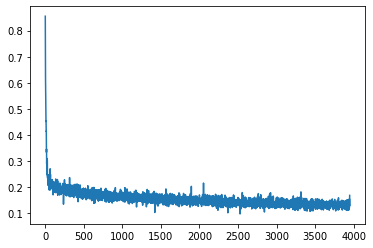

In [27]:
plt.plot(train_record['loss'])

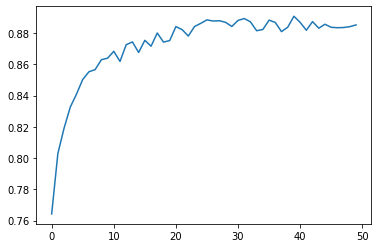

In [28]:
plt.plot(train_record['valid_acc'])

### Problem 0. Practice with nn.Sequential() (10 pts)
- `nn.Sequential` automatically stacks the `nn.Module`
    - If `x = nn.Sequential( nn.Conv1d(48, 12) , nn.ReLU() )`,
        - `out = x(input)` is same with `out` below
        - `x1 = nn.Conv1d(48,12)`, `x2=nn.ReLU()`, `out = x2(x1(input))`


In [82]:
class StackManualLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv1d(16, 4, kernel_size=2)
    self.activation = nn.Sigmoid()
    self.layer2 = nn.Conv1d(4, 4, kernel_size=2)
    self.layer3 = nn.Conv1d(4, 1, kernel_size=2)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activation(out)
    out = self.layer2(out)
    out = self.activation(out)
    out = self.layer3(out)
    return out

class SequentialLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      #TODO: Complete this nn.Sequential so that it computes exactly same thing with StackManualLayer
      nn.Conv1d(16, 4, kernel_size=2),
      nn.Sigmoid(),
      nn.Conv1d(4, 4, kernel_size=2),
      nn.Sigmoid(),
      nn.Conv1d(4, 1, kernel_size=2)
    )
  def forward(self, x):
    out = self.layers(x)
    return out
  
# Do not change the code below
torch.manual_seed(0)
manual_layer = StackManualLayer()
torch.manual_seed(0)
sequential_layer = SequentialLayer()

test_dummy = torch.arange(128).view(1,16,8).float()
manual_out = manual_layer(test_dummy)
print(f"Output with Manual Stack Layer: {manual_out}")
sequential_out = sequential_layer(test_dummy)
print(f"Output with Sequential Layer: {sequential_out}")

# The printed result has to be same


Output with Manual Stack Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<SqueezeBackward1>)
Output with Sequential Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<SqueezeBackward1>)


### Problem 1. Make Your Own Conv Layers (10 pts)
- Complete the `self.conv_layer` of `YourModel`
      

In [ ]:
class YourModel(AudioModel):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__(sr, n_fft, hop_length, n_mels, hidden_size, num_output)
    self.conv_layer = nn.Sequential(
      '''
      TODO: Complete your new conv layer 
      Example:
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      '''
    )

In [ ]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=50, loss_func=loss_func, device=DEV)

### Probelm 2. Try Various Settings and Report (40 pts)

### Problem 3 Complete Binary Cross Entropy Function (10 pts) 
- Complete the function that can calculate the Binary Cross Entropy for given prediction and target label without using `torch.BCELoss`


In [87]:
def get_binary_cross_entropy(pred:torch.Tensor, target:torch.Tensor):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input (assume that the value is output of sigmoid function)
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Loss value
  '''
  # TODO: Complete this function
  return 

batch = next(iter(valid_loader))
# pred = model(batch[0])

In [31]:
batch[1].shape

torch.Size([256, 51])

### Problem 4. Complete Precision-Recall Area Under Curve Function (10 pts)
- You can refer the pre-defined `get_roc_auc` function

In [86]:
def get_precision_recall_auc(pred:torch.Tensor, target:torch.Tensor, num_grid=500):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Area Under Curve value for Precision-Recall Curve
  '''
  # TODO: Complete This Function
  return

selected_model = model
pr_auc_value = validate_model(selected_model, valid_loader, DEV, acc_func=get_precision_recall_auc)
print(f"Calculated PR_AUC value is : {pr_auc_value}")

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

### Problem 5: Load audio and make prediction (20 pts)
- Upload mp3 file of your choice
    - If you are using Colab, you can upload file by opening File Browser at the sidebar
- Try several audio files and 
- You can get different result by modifying `THRESHOLD`
    - `THRESHOLD` has to be a value between 0 and 1
    - If you lower the `THRESHOLD`, more tags will be printed out
- Complete `slice_audio` function (5 pts)


In [23]:
your_audio_path = '9.mp3' #TODO
selected_model = model # Change it if you want to select model with different name

In [58]:
def slice_audio(audio_sample, sr, start_sec, end_sec):
  '''
  audio_sample (torch.Tensor): A sequence of audio samples in shape of (N,), where N is number of audio samples
  sr (int): Sampling rate of audio_sample
  start_sec (float): desired slice start position in seconds
  end_sec (float): desired slice end position in seconds
  
  output (torch.Tensor): A sequence of audio samples in shape of (int(sr*(end_sec-start_sec)), ) 
  '''
  # TODO: Complete this function
  return audio_sample

In [56]:
THRESHOLD = 0.5
y, sr = torchaudio.load(your_audio_path)
if sr!= selected_model.sr:
  y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=selected_model.sr)
if y.shape[0] > 1:
  y = torch.sum(y, dim=0) / y.shape[0]
sliced_y = slice_audio(y, seleted_model.sr, 0, 30) 
with torch.no_grad():
  pred = selected_model(sliced_y.unsqueeze(0).to(DEV)).to('cpu')
pred = pred.squeeze()
ipd.display(ipd.Audio(sliced_y, rate=selected_model.sr))
print(f"Predicted tags are: {model.vocab[pred>THRESHOLD]}")

Predicted tags are: ['guitar' 'piano' 'slow' 'no singer']


array(['guitar', 'slow'], dtype=object)